In [864]:
%reset 


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [865]:
%run  ./Kickit_app_transformers.py

In [866]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Reading the Data set

In [867]:
# reading the dataset
df_raw = pd.read_csv('kick.csv')

Extracting the axis of studies for the project custom to  ADESA website 

In [868]:
choosen_axis = ["Model", "Make" ,"Transmission","VehOdo","MMRAcquisitionAuctionAveragePrice", "IsBadBuy"]
df_adesa_raw = df_raw[choosen_axis]

df_adesa_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Model                              72983 non-null  object
 1   Make                               72983 non-null  object
 2   Transmission                       72983 non-null  object
 3   VehOdo                             72983 non-null  int64 
 4   MMRAcquisitionAuctionAveragePrice  72983 non-null  object
 5   IsBadBuy                           72983 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.3+ MB


# Pre-processing Pipeline for the freqency encoding technique

In [869]:
df_adesa_raw['Transmission'].value_counts()

AUTO      70398
MANUAL     2575
?             9
Manual        1
Name: Transmission, dtype: int64

In [870]:
df_adesa_raw['Transmission'] = df_adesa_raw['Transmission'].replace(['AUTO'], 1)
df_adesa_raw['Transmission'] = df_adesa_raw['Transmission'].replace(['MANUAL'], 0)
df_adesa_raw['Transmission'] = df_adesa_raw['Transmission'].replace(['Manual'], 0)
df_adesa_raw['Transmission'] = df_adesa_raw['Transmission'].replace(['?'], 0)


In [871]:
df_adesa_raw['Transmission'].value_counts()

1    70398
0     2585
Name: Transmission, dtype: int64

copying the raw data

In [872]:
df = df_adesa_raw.copy()

 Instantiating the preprocessing pipeline objects

In [873]:
'''this on will clean the dataset'''
f_preprocess = Kickit_dataframe_preprocessor()
'''this one will balance the dataset''' 
f_balancer = Kickit_dataframe_balancer()
''' this one will use the frequency encoding technique for categorical variable ''' 
freq_encoder = Kickit_frequency_encoder()

Creating a pipeline for the first preprocessing technique :based on count of  frequency encoder

In [874]:
freq_pipeline = Pipeline([("preprocess",f_preprocess),("balancer", f_balancer),
                          ("fencoder",freq_encoder)])

preprocessing the dataframe with the count of frequency pipeline

In [875]:
adesa_freq_pipe = freq_pipeline.fit_transform(df)

checking the transformation for success

In [876]:
adesa_freq_pipe.head(5)

,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,Model_encoded,Make_encoded
0,MAZDA3,MAZDA,1,89046,8155.0,0,42,267
1,1500 RAM PICKUP 2WD,DODGE,1,93593,6854.0,0,230,2923
2,STRATUS V6,DODGE,1,73807,3202.0,0,138,2923
3,NEON,DODGE,1,65617,1893.0,0,135,2923
4,FOCUS,FORD,0,69367,3913.0,0,244,2977


In [877]:
adesa_freq_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17724 entries, 0 to 17723
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Model                              17724 non-null  object 
 1   Make                               17724 non-null  object 
 2   Transmission                       17724 non-null  object 
 3   VehOdo                             17724 non-null  int64  
 4   MMRAcquisitionAuctionAveragePrice  17724 non-null  float64
 5   IsBadBuy                           17724 non-null  int64  
 6   Model_encoded                      17724 non-null  int64  
 7   Make_encoded                       17724 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 1.1+ MB


In [878]:
adesa_freq_pipe.drop('IsBadBuy', axis = 1).corr()

,VehOdo,MMRAcquisitionAuctionAveragePrice,Model_encoded,Make_encoded
VehOdo,1.000000,-0.055686,-0.034444,0.038481
MMRAcquisitionAuctionAveragePrice,-0.055686,1.000000,-0.156139,0.005129
Model_encoded,-0.034444,-0.156139,1.000000,0.257630
Make_encoded,0.038481,0.005129,0.257630,1.000000


###  Modelization based on frequency count

preparing and spliting the dataset for the modelization

In [879]:
features = adesa_freq_pipe.drop("IsBadBuy", axis =1)
target = adesa_freq_pipe["IsBadBuy"]
x_ftrain, x_ftest, y_ftrain, y_ftest = train_test_split(features, target, test_size=0.25, random_state=0)

Creating a list of pipelines for three different candidate classifiers

In [880]:
f_scaler = StandardScaler()
f_randomForest = RandomForestClassifier()
f_logisticRegr = LogisticRegression(random_state=0)
f_decisionTree = DecisionTreeClassifier()

freq_bench_cross = [Pipeline([("scaler",f_scaler), ('lr_classifier', f_logisticRegr)]),
                    Pipeline([('dt_classifier', f_decisionTree)]),
                    Pipeline([('rf_classifier', f_randomForest)])] 

In [881]:
# Dictionary of pipelines and classifier types for ease of reference
freq_pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest'}

# Fit the pipelines
for pipe in freq_bench_cross:
    pipe.fit(x_ftrain.drop(["Model", "Make"], axis =1), y_ftrain)

In [882]:
for i,model in enumerate(freq_bench_cross):
    print("{} with count of frequency Test Accuracy: {}".format(freq_pipe_dict[i],model.score(x_ftest.drop(["Model", "Make"], axis =1),y_ftest)))

Logistic Regression with count of frequency Test Accuracy: 0.5899345520198601
Decision Tree with count of frequency Test Accuracy: 0.5513428120063191
RandomForest with count of frequency Test Accuracy: 0.5888061385691717


# Pipelines for the Weight of Evidence  encoding technique

### Preprocessing the dataframe with the weight of evidence pipeline

 Instantiating the pipeline object

In [883]:
# this on will clean the data with respect to our requirements
w_preprocess = Kickit_dataframe_preprocessor()
# this one will balance the dataset
w_balancer = Kickit_dataframe_balancer()
# # this one will use the weight of evidence encoding technique for categorical variable 
woe_encoder = Kickit_weight_of_evidence_encoder()

#Creating a pipeline for the second  preprocessing technique :based on the weight of evidence encoder

In [884]:
woe_pipeline = Pipeline([("preprocess",w_preprocess),("balancer", w_balancer),
                         ("woe_encoder", woe_encoder),("2nd balancer", w_balancer)])

preprocessing the dataframe with the weight of evidence pipeline

In [885]:
# the next command  after this will raise an unecessary warning message, this will help keep the notebook clean
warnings.filterwarnings('ignore')

In [886]:
adesa_woe_pipe = woe_pipeline.fit_transform(df)

In [887]:
adesa_woe_pipe['IsBadBuy'].sum()

8180

In [888]:
# checking results
adesa_woe_pipe.head(5)

,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,Model_encoded,Make_encoded
0,MAZDA3,MAZDA,1,89046,8155.0,0,0.376478,-0.256720
1,1500 RAM PICKUP 2WD,DODGE,1,93593,6854.0,0,-0.156161,0.199403
2,STRATUS V6,DODGE,1,73807,3202.0,0,0.499331,0.199403
3,NEON,DODGE,1,65617,1893.0,0,-0.590075,0.199403
4,FOCUS,FORD,0,69367,3913.0,0,-0.570053,-0.288186


In [889]:
# Checking the dictionary from our encoding class created for each category
woe_cat_dict

{'1500 RAM PICKUP 2WD': -0.15616073075528253,
 '1500 RAM PICKUP 4WD': -0.3677247801253174,
 '1500 SIERRA PICKUP 2': 0.4895482253187058,
 '1500 SILVERADO PICKU': 0.7073318155519017,
 '2500 RAM PICKUP 2WD': -0.5108256237659907,
 '2500HD SILVERADO PIC': -0.587786664902119,
 '300': 0.8226812327518476,
 '300 2.7L V6 MPI': 1.0986122886681098,
 '300M': -1.0986122886681098,
 '300M 3.5L V6 MPI': -0.8472978603872037,
 'ACCENT': -0.04348511193973878,
 'ACCENT 1.6L I4 MPI': -0.4228568508200336,
 'ACCORD 4C': 0.5877866649021191,
 'ACCORD 4C 2.4L I-4 M': 0.8472978603872037,
 'ACCORD V6': 0.8209805520698303,
 'ACCORD V6 3.0L V6 EF': 0.5877866649021191,
 'ALERO 4C': 0.14842000511827322,
 'ALERO 4C 2.2L I4 MPI': -0.7884573603642702,
 'ALERO V6': -1.466337068793427,
 'ALERO V6 3.4L V6 MPI': -0.6359887667199967,
 'ALTIMA': 0.17010596902583072,
 'ALTIMA 2.5L I4 EFI': -0.9382696385929302,
 'ALTIMA 2.5L I4 MPI': 0.23180161405732438,
 'AMANTI': 0.5877866649021191,
 'AMANTI 3.5L V6 MPI': -0.25131442828090605,

In [890]:
adesa_woe_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16360 entries, 0 to 16359
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Model                              16360 non-null  object 
 1   Make                               16360 non-null  object 
 2   Transmission                       16360 non-null  object 
 3   VehOdo                             16360 non-null  int64  
 4   MMRAcquisitionAuctionAveragePrice  16360 non-null  float64
 5   IsBadBuy                           16360 non-null  int64  
 6   Model_encoded                      16360 non-null  float64
 7   Make_encoded                       16360 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 1022.6+ KB


# Feature ingineering

In [891]:
adesa_woe_pipe.Make.value_counts().max(), adesa_woe_pipe.Make.value_counts().min() , adesa_woe_pipe.Make.value_counts().mean()

(3754, 3, 654.4)

In [892]:
adesa_woe_pipe.Model.value_counts().max(), adesa_woe_pipe.Model.value_counts().min(), adesa_woe_pipe.Model.value_counts().mean()

(645, 1, 37.4370709382151)

In [893]:
adesa_woe_pipe.Transmission.value_counts().max(), adesa_woe_pipe.Transmission.value_counts().min() ,adesa_woe_pipe.Transmission.value_counts().mean()

(15848, 512, 8180.0)

# MAKE feature

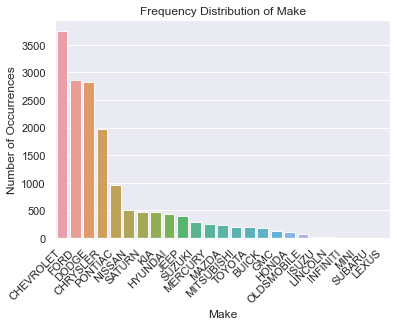

In [894]:
import seaborn as sns
import  matplotlib.pyplot as plt
model_count = adesa_woe_pipe.Make.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

resampling make feature 

In [895]:
adesa_woe_pipe["Model"][adesa_woe_pipe["Make"]== 'MAZDA']

0                      MAZDA3
68                     MAZDA5
126                    MAZDA6
136                    MAZDA3
204                    MAZDA3
                 ...         
15924                  MAZDA6
15991                  MAZDA6
16005                 PROTEGE
16174    MPV 2WD V6 3.0L V6 M
16313     TRIBUTE 4WD V6 3.0L
Name: Model, Length: 229, dtype: object

In [896]:
max_col_cvalue

NameError: name 'max_col_cvalue' is not defined

In [897]:
import random
df_oversample = adesa_woe_pipe
zero_targets_counter = 0
row_list2 =[]
colist = adesa_woe_pipe["Make"].unique().tolist()
key = colist
value = random.sample(range(3,45,1), 25)
noise_dict = dict(zip(key, value))
for col , noise in noise_dict.items():   
    msk = adesa_woe_pipe["Make"] == col
    num_to_oversample =  adesa_woe_pipe["Make"].value_counts().max() - msk.sum() + noise
    df_positive_oversample = adesa_woe_pipe[msk].sample(n=num_to_oversample, replace =True)
    df_oversample = pd.concat([df_oversample, df_positive_oversample])
   
        
        

In [898]:
adesa_woe_pipe["Make"].value_counts().mean()

654.4

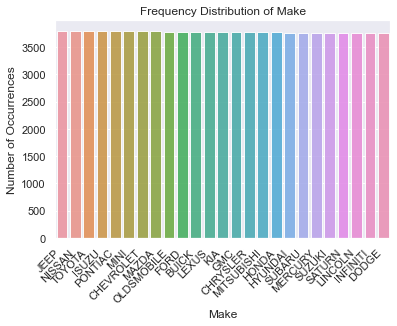

In [899]:
model_count = df_oversample["Make"].value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

In [900]:
df_oversample['Model'][df_oversample['Make'] =='FORD'].value_counts()

TAURUS                  530
TAURUS 3.0L V6 EFI      372
FOCUS                   329
FIVE HUNDRED            154
FUSION 4C               140
                       ... 
EXPLORER 2WD V8 4.6L      7
TAURUS X FWD V6           6
TAURUS 3.0L V6 EFI D      6
FREESTAR FWD V6 4.2L      4
TAURUS 3.0L V6 EFI /      4
Name: Model, Length: 61, dtype: int64

# Study for Model

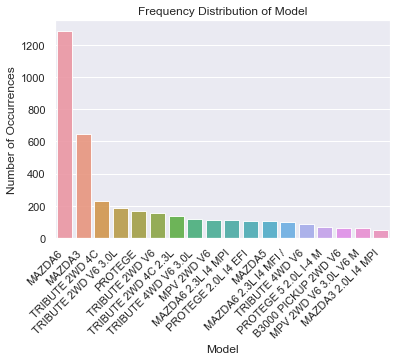

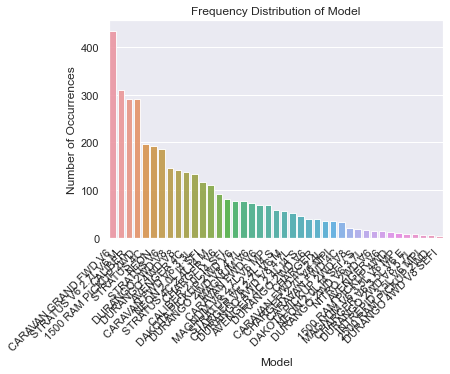

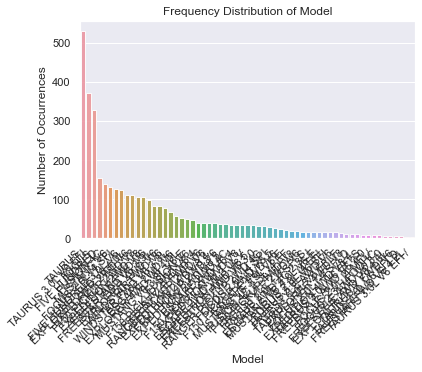

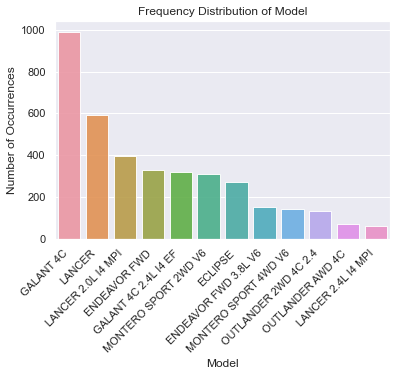

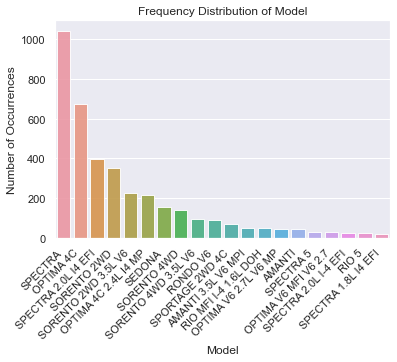

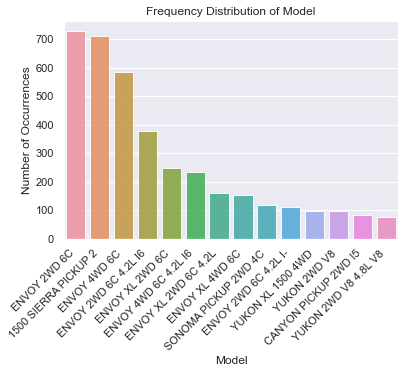

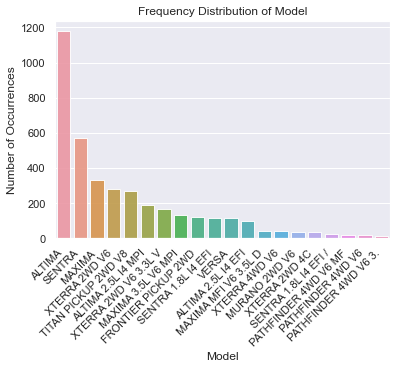

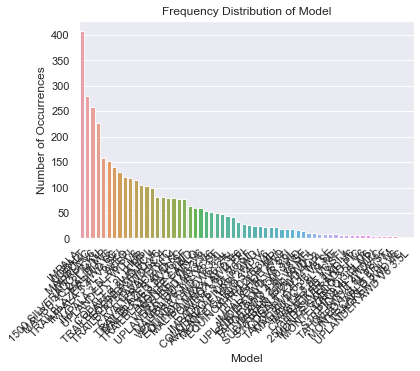

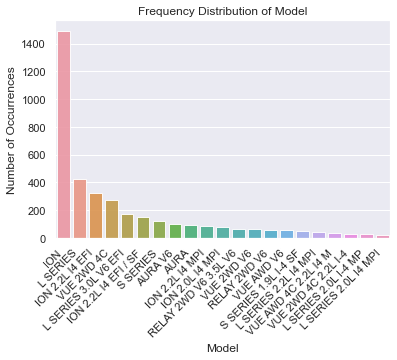

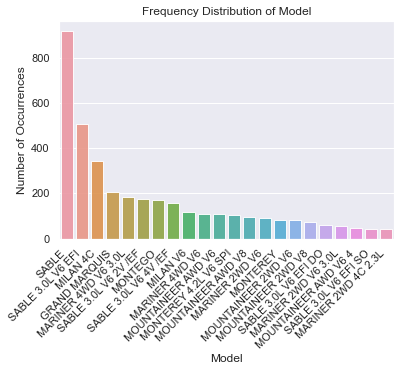

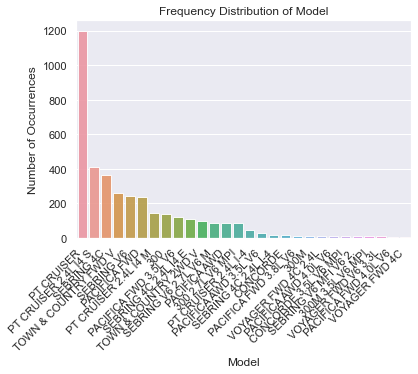

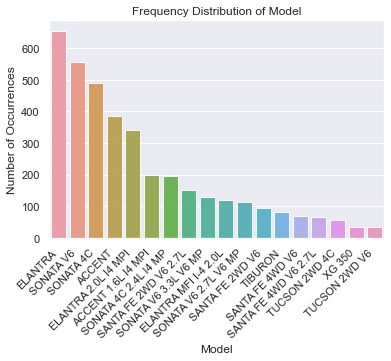

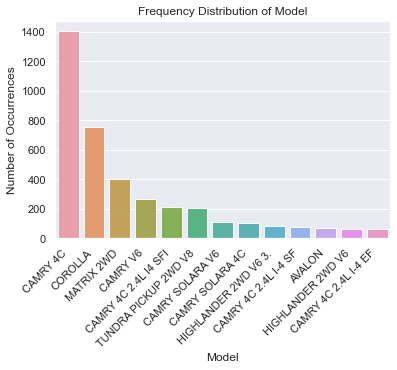

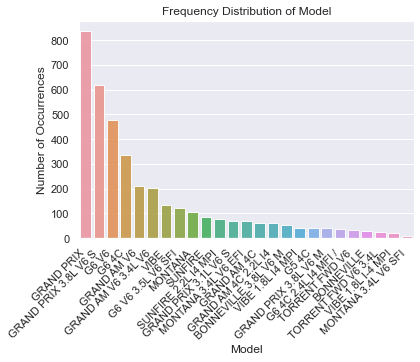

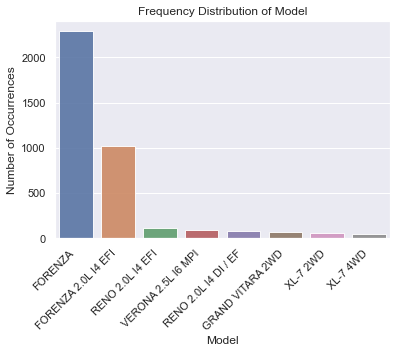

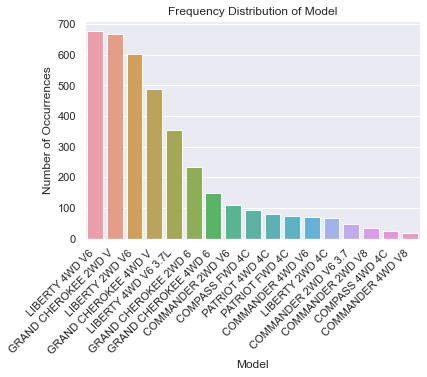

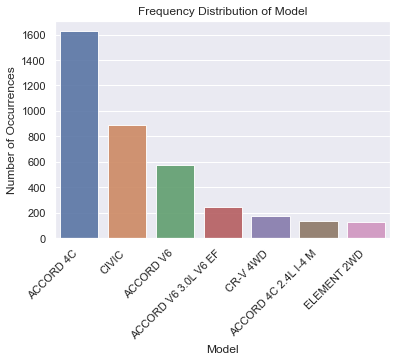

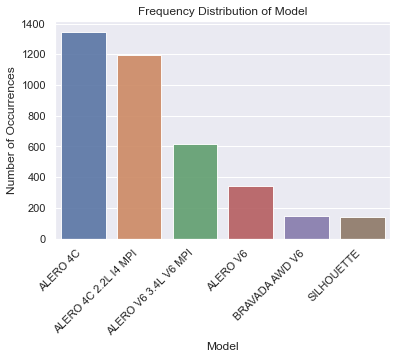

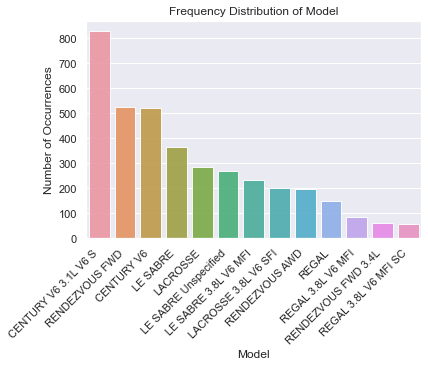

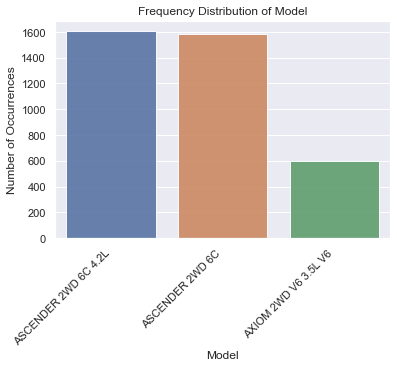

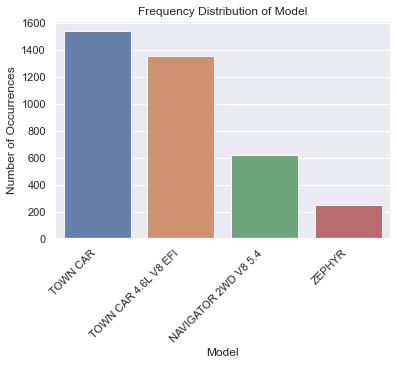

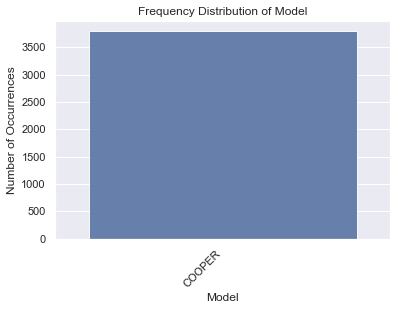

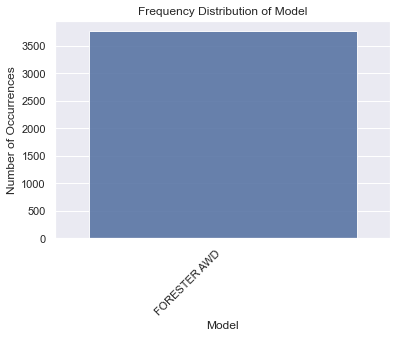

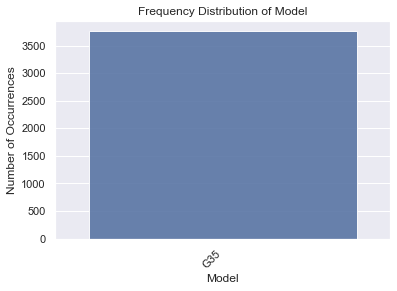

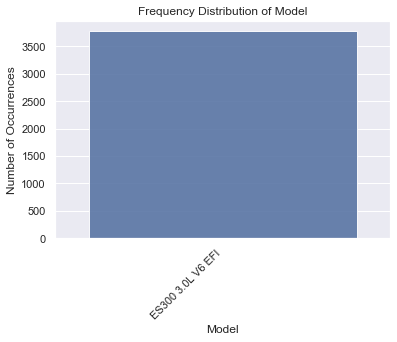

In [901]:
# initial plot of the model count
# for each make , plot the frequency distribution of its models
for make in df_oversample['Make'].unique():
        model_count = df_oversample['Model'][df_oversample['Make'] == make].value_counts()
        sns.set(style="darkgrid")
        chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
        plt.title('Frequency Distribution of Model')
        plt.ylabel('Number of Occurrences')
        plt.xlabel('Model')
        plt.show()

In [902]:
 # for each make, return and assign a new column with 70% threshold of cumulated total values, and set a mask as  'Other' to the remaining 10% 
for make in df_oversample['Make'].unique():
    transf_model_column,new_category_list=cumulatively_categorise(df_oversample['Model'][df_oversample['Make'] == make],threshold = 0.70, return_categories_list=True)
    df_oversample['Model'][df_oversample['Make'] == make] = transf_model_column

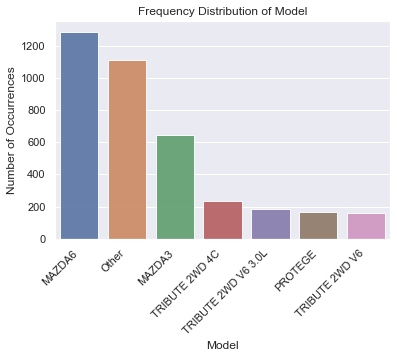

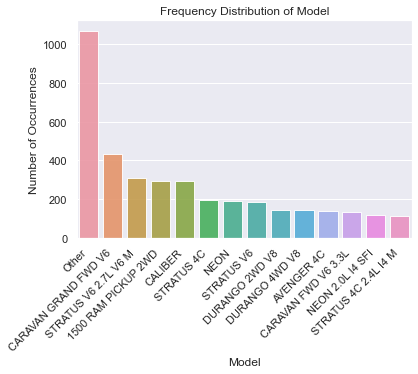

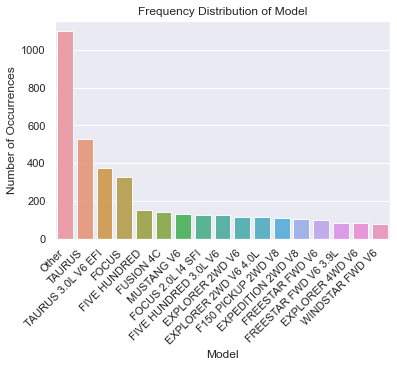

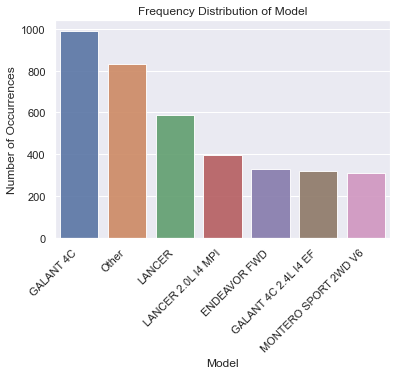

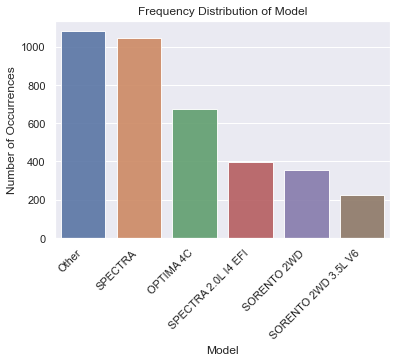

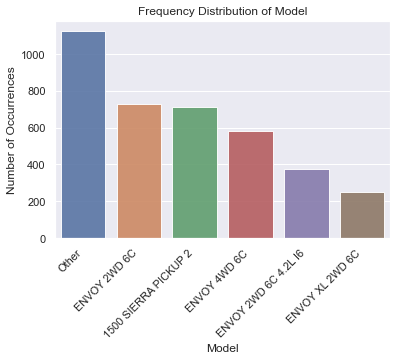

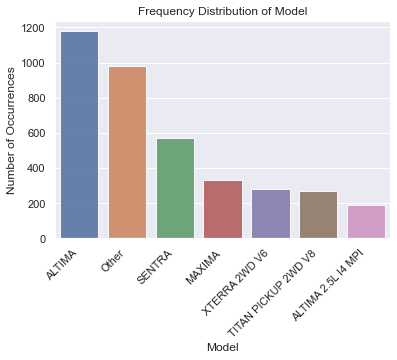

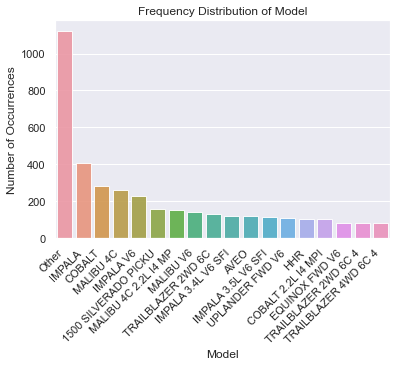

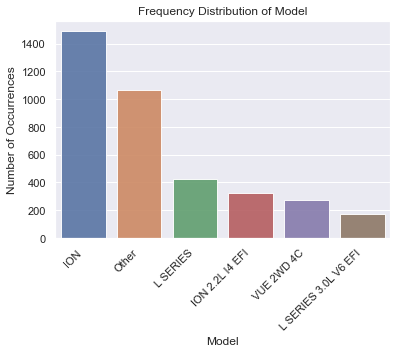

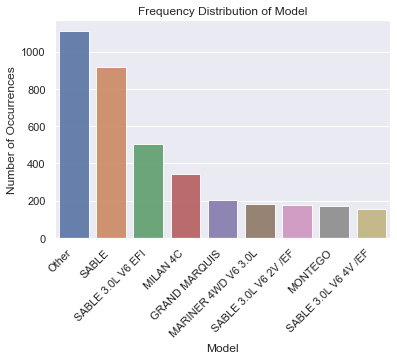

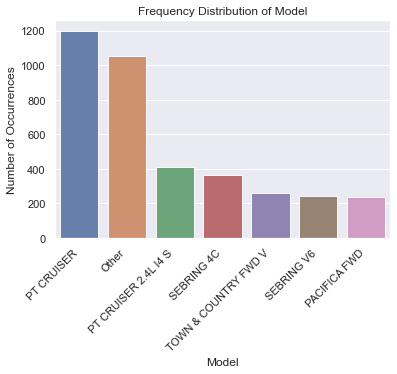

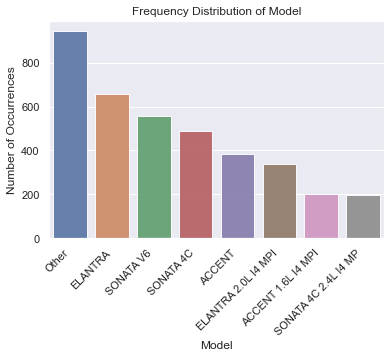

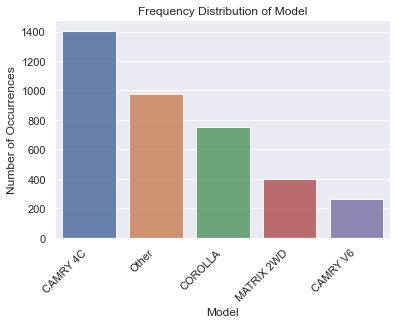

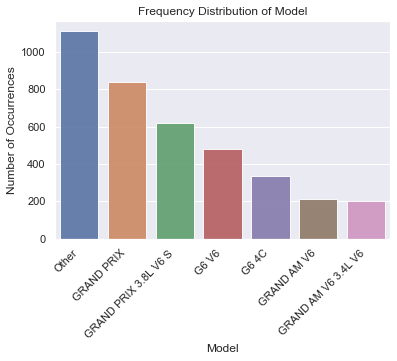

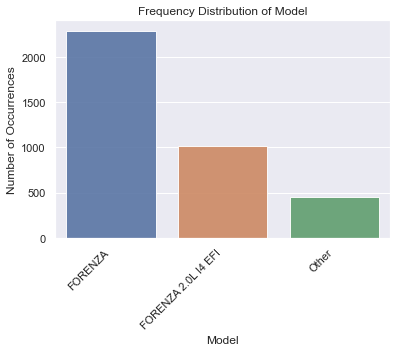

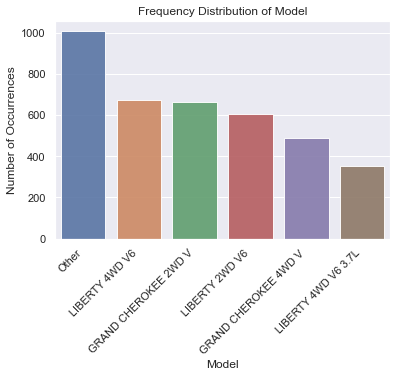

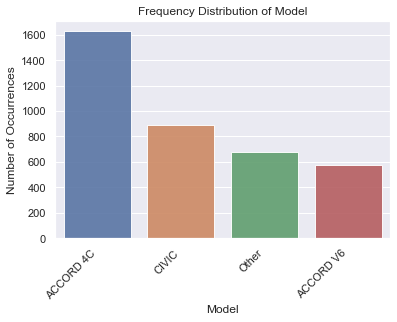

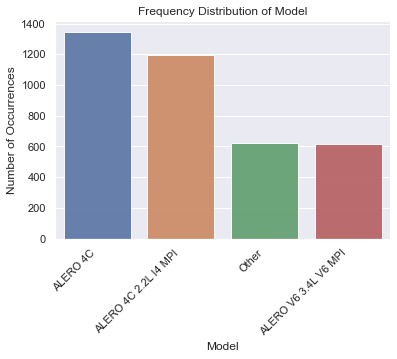

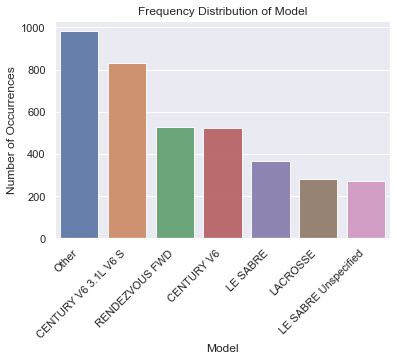

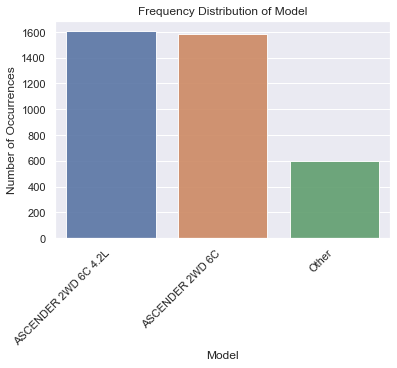

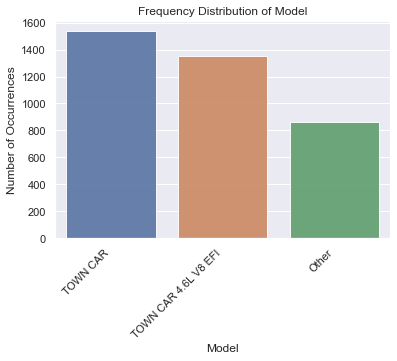

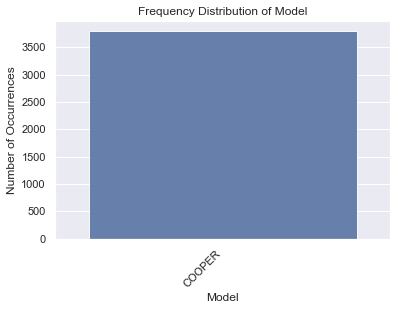

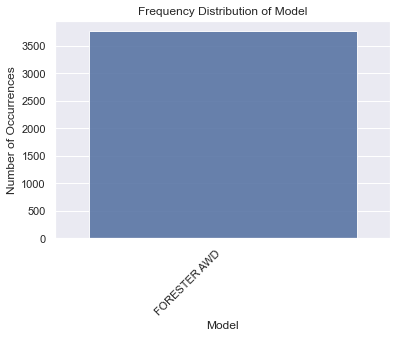

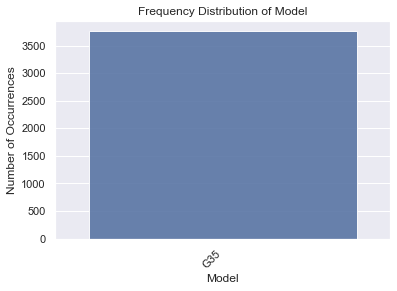

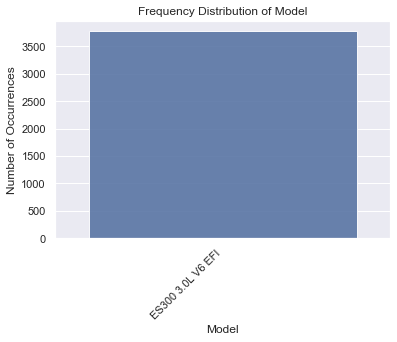

In [903]:
# Replotting with mask ('Other'): 
#for each make , plot the frequency distribution of its model

for make in df_oversample['Make'].unique():
        model_count = df_oversample['Model'][df_oversample['Make'] == make].value_counts()
        sns.set(style="darkgrid")
        chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
        plt.title('Frequency Distribution of Model')
        plt.ylabel('Number of Occurrences')
        plt.xlabel('Model')
        plt.show()

In [904]:
adesa_woe_pipe['Model'][adesa_woe_pipe['Make'] == 'BUICK'].value_counts()

CENTURY V6 3.1L V6 S    38
CENTURY V6              26
RENDEZVOUS FWD          25
LE SABRE                18
LACROSSE                13
LE SABRE Unspecified    13
LE SABRE 3.8L V6 MFI    12
RENDEZVOUS AWD          10
LACROSSE 3.8L V6 SFI     9
REGAL                    7
REGAL 3.8L V6 MFI        4
RENDEZVOUS FWD 3.4L      3
REGAL 3.8L V6 MFI SC     3
Name: Model, dtype: int64

In [ ]:
colists = adesa_woe_pipe[adesa_woe_pipe['Make'] == 'BUICK'].value
max_col_cvalue = adesa_woe_pipe['Model'][adesa_woe_pipe['Make'] == 'BUICK'].value_counts().max()
msk = adesa_woe_pipe['Make'] == 'BUICK'
num_to_undersample =     int(adesa_woe_pipe['Model'][adesa_woe_pipe['Make'] == 'BUICK'].value_counts().mean()) #+ noise
df_positive_oversample = adesa_woe_pipe[msk].sample(n=num_to_undersample, replace =True)
df_positive_oversample['Model'][adesa_woe_pipe['Make'] == 'BUICK'].value_counts().sum()

In [906]:
df_oversample_with_model = df_oversample
for make in df_oversample_with_model['Make'].unique():
    colist = df_oversample_with_model['Model'][df_oversample_with_model['Make'] == make].unique().tolist()
    key = colist
    value = random.sample(range(1,2*len(key),1), len(key))
    noise_dict = dict(zip(key, value))
    for col , noise in noise_dict.items():
        max_col_cvalue = df_oversample_with_model["Model"][df_oversample_with_model["Make"]== col].value_counts().max()
        mean_col_cvalue = int(df_oversample_with_model["Make"].value_counts().mean())
        if max_col_cvalue < mean_col_cvalue:    
            msk = df_oversample_with_model['Model'][df_oversample_with_model['Make'] == make] == col
            num_to_oversample =  df_oversample_with_model['Model'][df_oversample_with_model['Make'] == make].value_counts().max() - msk.sum() + noise +1
            df_positive_oversample = df_oversample_with_model[df_oversample_with_model['Make'] == make][msk].sample(n=num_to_oversample, replace =True)
            df_oversample_with_model = pd.concat([df_oversample_with_model, df_positive_oversample])
        elif max_col_cvalue > mean_col_cvalue:
            msk = df_oversample_with_model["Make"] == col
            num_to_undersample =   max_col_cvalue - int(df_oversample_with_mode["Make"].value_counts().mean()) + noise
            df_positive_oversample = df_oversample_with_model[msk].sample(n=num_to_undersample, replace =True)
            df_oversample_with_model = pd.concat([df_oversample_with_model, df_positive_oversample])

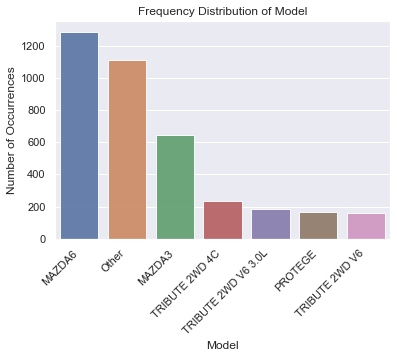

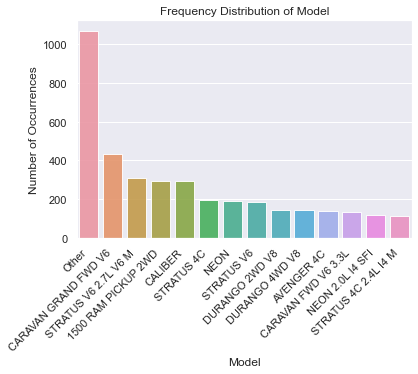

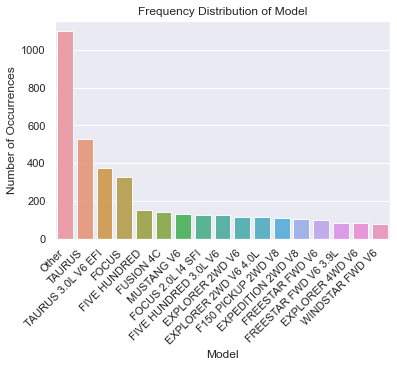

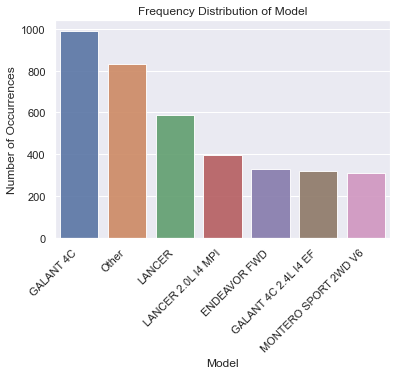

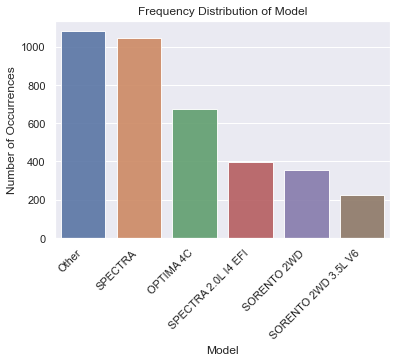

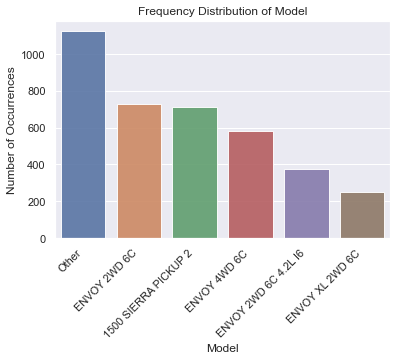

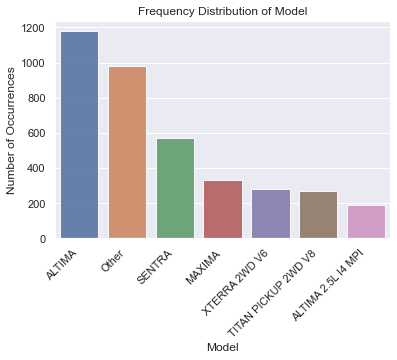

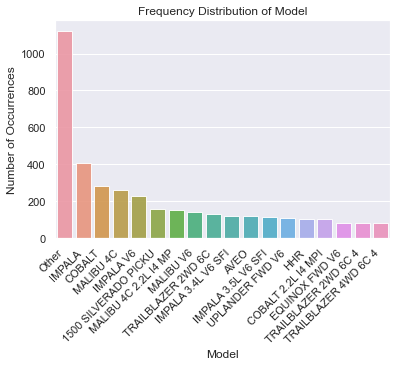

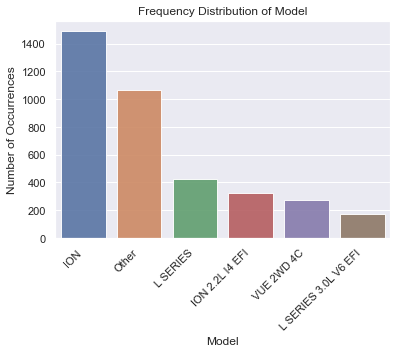

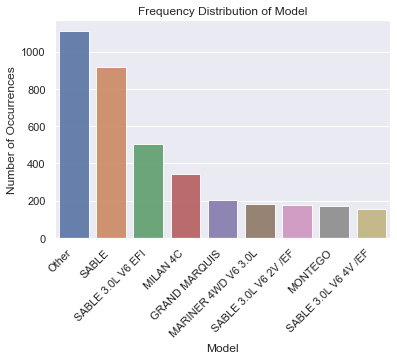

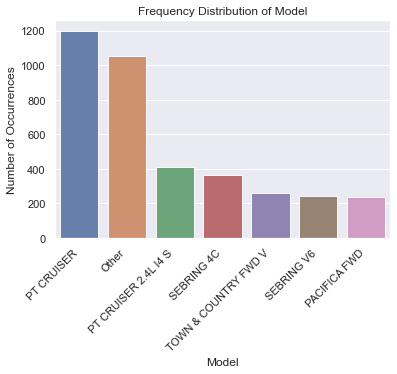

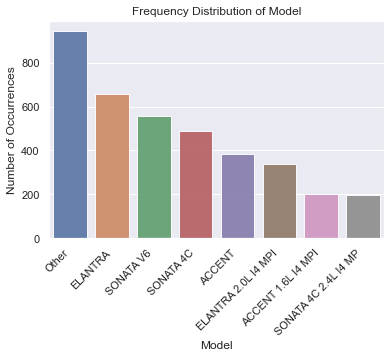

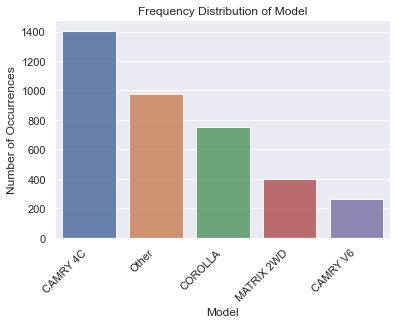

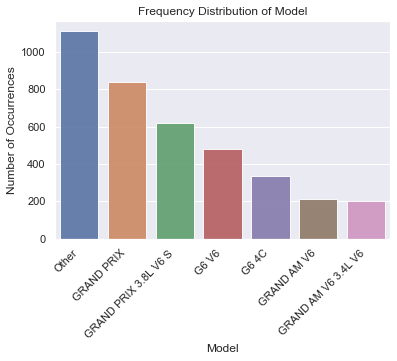

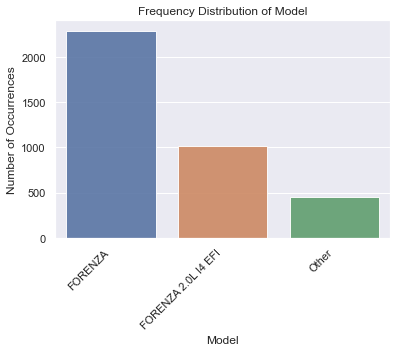

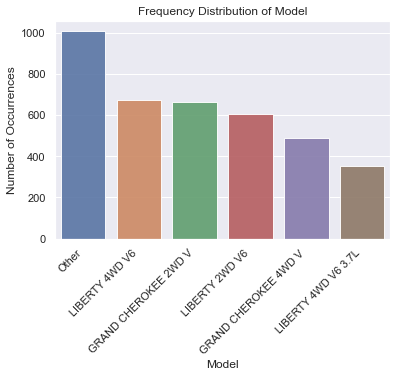

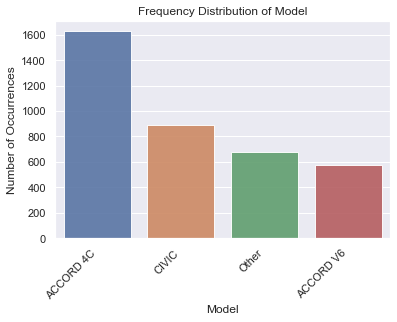

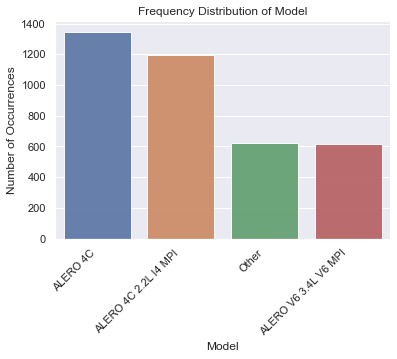

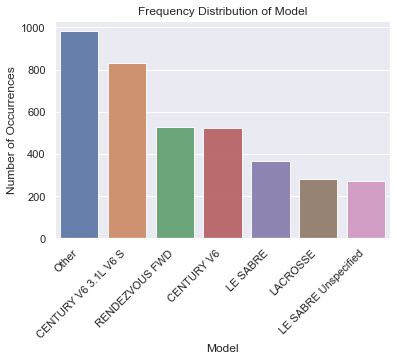

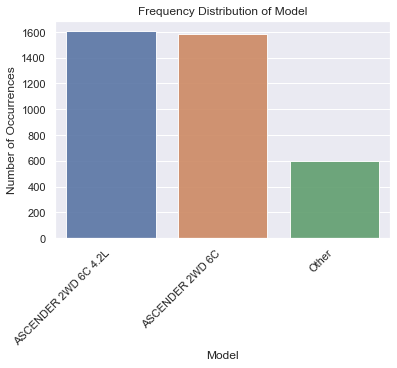

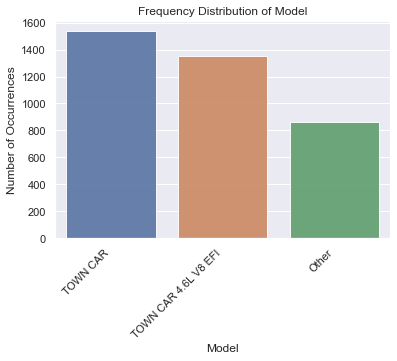

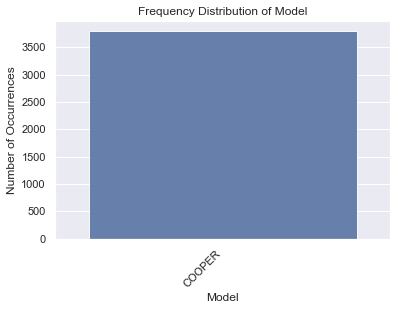

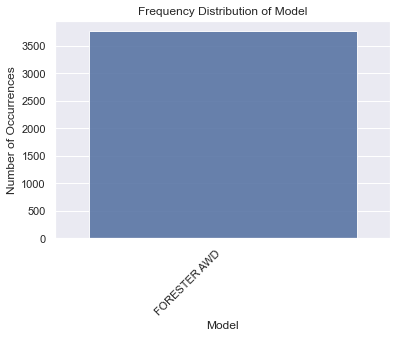

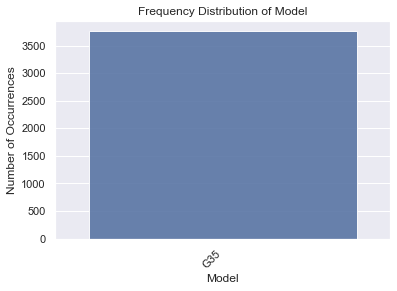

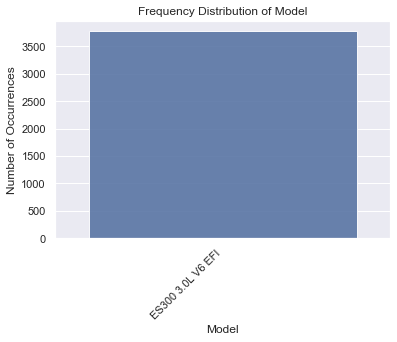

In [907]:
for make in df_oversample_with_model['Make'].unique():
        model_count = df_oversample_with_model['Model'][df_oversample_with_model['Make'] == make].value_counts()
        sns.set(style="darkgrid")
        chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
        plt.title('Frequency Distribution of Model')
        plt.ylabel('Number of Occurrences')
        plt.xlabel('Model')
        plt.show()

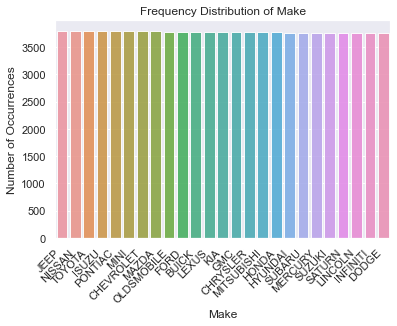

In [908]:
#recheck the make frequency distribution
model_count = df_oversample_with_model.Make.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

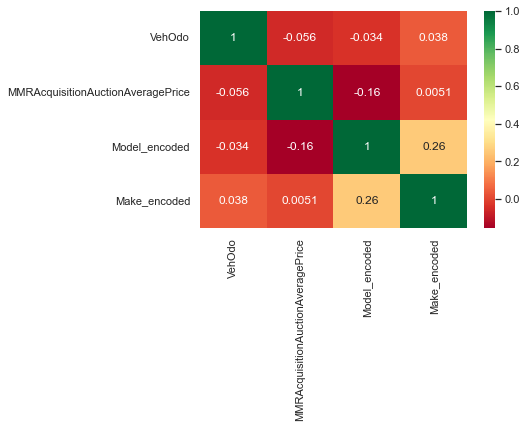

In [909]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = df_oversample_with_model.drop('IsBadBuy', axis = 1).corr()
top_corr_features = corrmat.index
plt.figure()
#plot heat map
g=sns.heatmap(adesa_freq_pipe.drop('IsBadBuy', axis = 1)[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Modelization based on WOE 

In [434]:
df = df_adesa_raw.copy()

In [435]:
#features = df
#target = df["IsBadBuy"]

#x_wtrain, x_wtest, y_wtrain, y_wtest = train_test_split(features, target, test_size=0.25, random_state=0, stratify =df['Make']  )

In [436]:
#features = df
#target = df["IsBadBuy"]
#x_wtrain, x_wtest, y_wtrain, y_wtest = train_test_split(features, target, test_size=0.25, random_state=0, stratify = )

In [910]:
#features = adesa_woe_pipe
#target = adesa_woe_pipe["IsBadBuy"]
#x_wtrain, x_wtest, y_wtrain, y_wtest = train_test_split(features, target, test_size=0.25, random_state=0)

features = df_oversample_with_model
target = df_oversample_with_model["IsBadBuy"]
x_wtrain, x_wtest, y_wtrain, y_wtest = train_test_split(features, target, test_size=0.25, random_state=0, stratify = target )

In [911]:
x_wtrain["IsBadBuy"].shape[0]

70794

In [912]:
x_wtrain["IsBadBuy"].shape[0]

70794

In [913]:
w_scaler = StandardScaler()
w_randomForest = RandomForestClassifier(class_weight="balanced")
w_logisticRegr = LogisticRegression(random_state=0)
w_decisionTree = DecisionTreeClassifier()

# Creating a list of pipelines for three different candidate classifiers 
woe_bench_cross = [Pipeline([("scaler",w_scaler), ('lr_classifier', w_logisticRegr)]),
                    Pipeline([('dt_classifier', w_decisionTree)]),
                    Pipeline([('rf_classifier', w_randomForest)])] 

In [914]:
x_wtrain

,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,Model_encoded,Make_encoded
12200,Other,NISSAN,1,81425,5156.0,1,-1.021651,-0.244453
16072,Other,HYUNDAI,1,63977,5363.0,1,0.847298,0.118590
8763,ES300 3.0L V6 EFI,LEXUS,1,63477,8415.0,0,-0.510826,-0.510826
14630,ENVOY 2WD 6C 4.2L I6,GMC,1,83462,6955.0,1,0.435318,0.263045
7377,PT CRUISER 2.4L I4 S,CHRYSLER,1,79377,3526.0,0,-0.241552,-0.161349
...,...,...,...,...,...,...,...,...
14555,ALERO 4C,OLDSMOBILE,1,74020,2659.0,1,0.148420,-0.489548
8594,ENVOY 2WD 6C 4.2L I6,GMC,1,81842,8653.0,0,0.435318,0.263045
625,COOPER,MINI,1,81188,8329.0,0,-0.336472,-0.336472
867,OPTIMA 4C,KIA,1,69191,7529.0,0,0.304660,0.070569


In [915]:
# Dictionary of pipelines and classifier types for ease of reference
woe_pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: ' Default mode RandomForest'}

# Fit the pipelines
for pipe in woe_bench_cross:
    pipe.fit(x_wtrain.drop(["IsBadBuy", "Model", "Make"], axis =1), y_wtrain)

In [916]:
for i,model in enumerate(woe_bench_cross):
    print("{} with Weight of evidence Test Accuracy: {}".format(woe_pipe_dict[i],model.score(x_wtest.drop(["IsBadBuy", "Model", "Make"], axis =1),y_wtest)))

Logistic Regression with Weight of evidence Test Accuracy: 0.6405203830833122
Decision Tree with Weight of evidence Test Accuracy: 0.9524112212899398
 Default mode RandomForest with Weight of evidence Test Accuracy: 0.9545724213916433


In [917]:
best_model = w_randomForest

In [918]:
best_model.score(x_wtest.drop(["IsBadBuy", "Model", "Make"], axis =1),y_wtest)

0.9545724213916433

In [919]:
best_model.predict(x_wtest.drop(["IsBadBuy", "Model", "Make"], axis =1))

array([0, 1, 1, ..., 0, 0, 1], dtype=int64)

In [920]:
file = open('model.pkl', 'wb')
pickle.dump(best_model, file)

In [926]:
file = open('kidict.pkl', 'wb')
pickle.dump(woe_cat_dict, file)

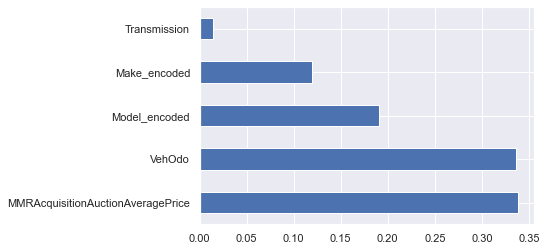

In [925]:
#plot graph of feature importances for the model
%matplotlib inline            

feat_importances = pd.Series(best_model.feature_importances_, index=x_wtest.drop(["IsBadBuy", "Model", "Make"], axis =1).columns)
feat_importances.nlargest(6).plot(kind='barh')
plt.show()

In [861]:
x_wtest['predicted_label'] = best_model.predict(x_wtest.drop(["IsBadBuy","Model","Make"], axis =1))

In [927]:
test = x_wtest.drop(["Model_encoded", "Make_encoded"], axis =1)
test.head(20)

,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy
621,COOPER,MINI,0,74398,5913.0,0
13392,SONATA 4C,HYUNDAI,1,54705,6593.0,1
11060,ENVOY 2WD 6C,GMC,1,94785,6969.0,1
12182,COOPER,MINI,1,78170,6523.0,1
14037,Other,MERCURY,1,72335,6875.0,1
1829,SABLE,MERCURY,1,56742,5600.0,0
1551,Other,SUZUKI,1,92146,7393.0,1
12671,ALTIMA,NISSAN,1,92254,7733.0,1
5106,TAURUS 3.0L V6 EFI,FORD,1,74260,2652.0,0
508,TOWN CAR 4.6L V8 EFI,LINCOLN,1,57000,3786.0,1


In [929]:
file = open('test.pkl', 'wb')
pickle.dump(test, file)

In [863]:
from sklearn.metrics import confusion_matrix
y_true = test['IsBadBuy']
y_pred = test['predicted_label']
confusion_matrix(y_true, y_pred)

array([[10753,   502],
       [  513, 11852]], dtype=int64)

# Results

The best pipeline between the frequency encoding and the weight of evidence encoding is  : Weight of evidence one 

The best model within that pipeline is : Logistic regression  then Upgraded Random forest models with the same score

saving the created encoding dictionnary for interpretation in the flask part

saving the selected model

In [88]:
file = open('model.pkl', 'wb')
pickle.dump(Upgraded_Random_frorest, file)

# Test

In [89]:
a = Upgraded_Random_frorest.predict(x_wtest.drop(["IsBadBuy",
                                                  "Model",
                                                  "Make",
                                                  "Transmission"], axis =1))
a

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [90]:
len(a)

4090

In [91]:
a.sum()

2116

In [92]:
x_wtest['predicted_label'] = Upgraded_Random_frorest.predict(x_wtest.drop(["IsBadBuy",
                                                                           "Model", 
                                                                           "Make",
                                                                           "Transmission"], axis =1))

In [93]:
x_wtest.head(5) 


,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,Model_encoded,Make_encoded,Transmission_encoded,predicted_label
12540,ALTIMA,NISSAN,AUTO,86450,4165.0,1,0.170106,-0.244453,0.027895,1
2606,VENTURE FWD V6,CHEVROLET,AUTO,78136,3382.0,0,-0.072759,0.352315,0.027895,1
5911,CAVALIER 4C,CHEVROLET,AUTO,50887,2977.0,0,-0.463837,0.352315,0.027895,1
7862,CALIBER,DODGE,AUTO,90387,7197.0,0,-0.489548,0.199403,0.027895,1
1534,TAURUS,FORD,AUTO,71364,2259.0,0,-0.029632,-0.288186,0.027895,1


In [94]:
woe_cat_dict.get('IMPALA')

0.47354624267324213

In [95]:
test = x_wtest.drop(["Model_encoded", "Make_encoded","Transmission_encoded"], axis =1)
test.head(20)

,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,predicted_label
12540,ALTIMA,NISSAN,AUTO,86450,4165.0,1,1
2606,VENTURE FWD V6,CHEVROLET,AUTO,78136,3382.0,0,1
5911,CAVALIER 4C,CHEVROLET,AUTO,50887,2977.0,0,1
7862,CALIBER,DODGE,AUTO,90387,7197.0,0,1
1534,TAURUS,FORD,AUTO,71364,2259.0,0,1
574,COBALT,CHEVROLET,MANUAL,88170,5092.0,0,1
10172,STRATUS V6,DODGE,AUTO,64554,3228.0,1,0
14897,DURANGO 4WD V8 4.7L,DODGE,AUTO,89416,9116.0,1,0
12148,EXPEDITION 2WD V8,FORD,AUTO,91769,8446.0,1,1
5543,IMPALA,CHEVROLET,AUTO,68515,8015.0,0,0


In [96]:
from sklearn.metrics import confusion_matrix
y_true = test['IsBadBuy']
y_pred = test['predicted_label']
confusion_matrix(y_true, y_pred)

array([[1235,  777],
       [ 739, 1339]], dtype=int64)

In [97]:
test.describe() 
#test[test.MMRAcquisitionAuctionAveragePrice == 0]

,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,predicted_label
count,4090.000000,4090.000000,4090.000000,4090.000000
mean,73238.441809,5781.391443,0.508068,0.517359
std,14078.099940,2365.500054,0.499996,0.499760
min,12628.000000,10.000000,0.000000,0.000000
25%,64135.000000,3880.250000,0.000000,0.000000
50%,74673.000000,5547.500000,1.000000,1.000000
75%,83582.250000,7386.000000,1.000000,1.000000
max,115717.000000,17229.000000,1.000000,1.000000


In [98]:
test.Make.value_counts() #mask for lincoln

CHEVROLET     914
DODGE         722
FORD          708
CHRYSLER      478
PONTIAC       244
NISSAN        128
KIA           122
SATURN        119
HYUNDAI       114
JEEP          101
MERCURY        77
MITSUBISHI     61
SUZUKI         59
BUICK          49
MAZDA          47
TOYOTA         44
GMC            34
HONDA          32
OLDSMOBILE     20
LINCOLN         6
ISUZU           4
SUBARU          2
INFINITI        2
MINI            2
LEXUS           1
Name: Make, dtype: int64

In [99]:
# evaluate the model per car type
# same number of car and model
#same distribution in in the train and test set = train and test stratified (same distribution per categories) , 
#keycode in train test split , double stratification
# apply a Mask , for other, reduce 

#balancing (embe learn  , data augmentation) follows startification.

# pour quel marque ca marche bien 

In [100]:
# EDA + comments

In [101]:
Make_count = test.Make.value_counts()
make_mask = test.Make.isin(Make_count[Make_count < 100].index)
#test.Make[Make_mask] = 'Other Make'

In [102]:
model_count = test.Model.value_counts()
model_mask = test.Model.isin(model_count[model_count < 100].index)
#test.Model[model_mask] = 'Other Model'

In [103]:
from collections import Counter

In [104]:
counts=Counter(test.Make)
# summarize class distribution

counts

Counter({'NISSAN': 128,
         'CHEVROLET': 914,
         'DODGE': 722,
         'FORD': 708,
         'SATURN': 119,
         'BUICK': 49,
         'KIA': 122,
         'CHRYSLER': 478,
         'MAZDA': 47,
         'HONDA': 32,
         'JEEP': 101,
         'PONTIAC': 244,
         'HYUNDAI': 114,
         'MERCURY': 77,
         'SUZUKI': 59,
         'MITSUBISHI': 61,
         'GMC': 34,
         'TOYOTA': 44,
         'OLDSMOBILE': 20,
         'LINCOLN': 6,
         'ISUZU': 4,
         'SUBARU': 2,
         'INFINITI': 2,
         'MINI': 2,
         'LEXUS': 1})

# MAKE Category STUDY

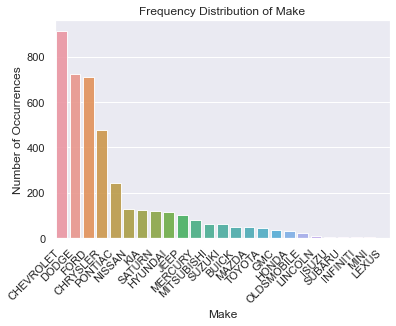

In [105]:
import seaborn as sns
import  matplotlib.pyplot as plt
model_count = test.Make.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

In [151]:
import random

In [191]:
df_oversample = test
colist = test["Make"].unique().tolist()
key = colist
value = random.sample(range(3,45,1), 25)
noise_dict = dict(zip(key, value))
for col , noise in noise_dict.items():
    msk = test["Make"] == col
    num_to_oversample =  test["Make"].value_counts().max() - msk.sum() + noise
    df_positive_oversample = test[msk].sample(n=num_to_oversample, replace =True)
    df_oversample = pd.concat([df_oversample, df_positive_oversample])

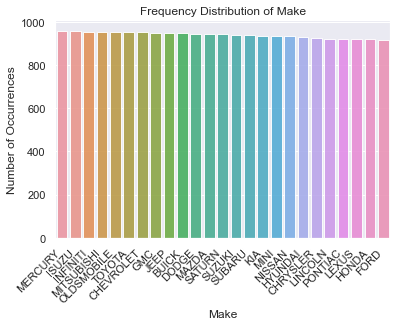

In [192]:
model_count = df_oversample.Make.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

# Study for Model

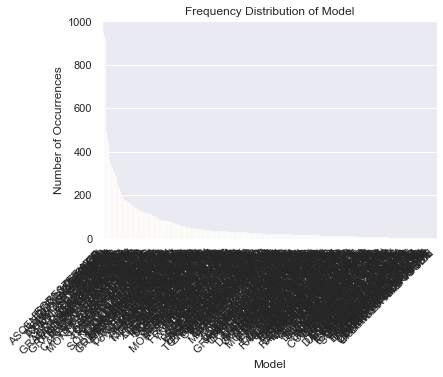

In [193]:
model_count = df_oversample.Model.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Model')
plt.ylabel('Number of Occurrences')
plt.xlabel('Model')
plt.show()

In [195]:
df_oversample.Model.value_counts()

G35                     954
FORESTER AWD            938
COOPER                  933
ES300 3.0L V6 EFI       919
FORENZA                 494
                       ... 
2500HD SILVERADO PIC      1
MONTE CARLO 3.5L V6       1
CONCORDE                  1
UPLANDER AWD V6 3.5L      1
DURANGO 4WD V8 SEFI       1
Name: Model, Length: 397, dtype: int64

In [196]:
#Call the function on the make column  with a  threshold of %
transf_model_column,new_category_list=cumulatively_categorise(df_oversample.Model,threshold = 0.90, return_categories_list=True)

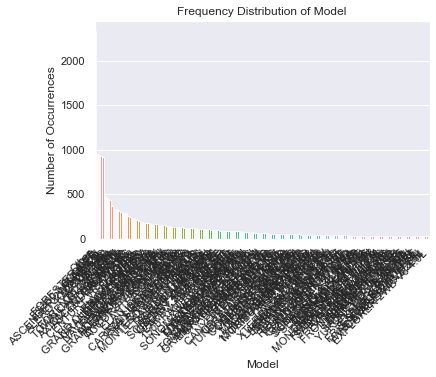

In [197]:
transf_model_column_count = transf_model_column.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(transf_model_column_count.index, transf_model_column_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Model')
plt.ylabel('Number of Occurrences')
plt.xlabel('Model')
plt.show()

In [198]:
df_oversample['Model'] = transf_model_column
df_oversample_with_model = df_oversample
colist = df_oversample['Model'].unique().tolist()
key = colist
value = random.sample(range(3,200,1), 186)
noise_dict = dict(zip(key, value))
for col , noise in noise_dict.items():
    msk = df_oversample["Model"] == col
    num_to_oversample =  df_oversample["Model"].value_counts().max() - msk.sum() + noise +1
    df_positive_oversample = df_oversample[msk].sample(n=num_to_oversample, replace =True)
    df_oversample_with_model = pd.concat([df_oversample_with_model, df_positive_oversample])

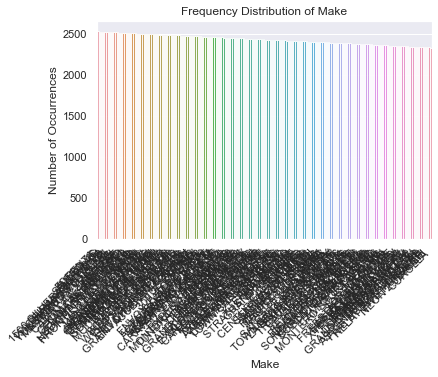

In [199]:
model_count = df_oversample_with_model.Model.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Model')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

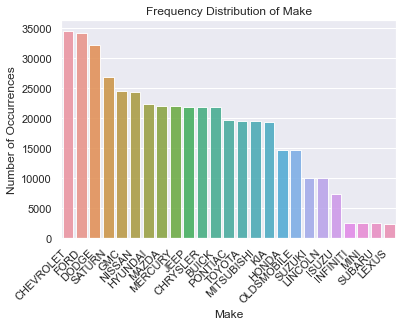

In [200]:
model_count = df_oversample_with_model.Make.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

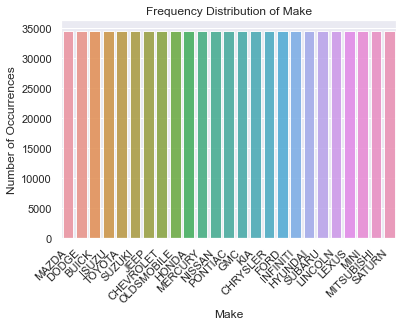

In [201]:
test = df_oversample_with_model
df_oversample = test
colist = test["Make"].unique().tolist()
key = colist
value = random.sample(range(3,45,1), 25)
noise_dict = dict(zip(key, value))
for col , noise in noise_dict.items():
    msk = test["Make"] == col
    num_to_oversample =  test["Make"].value_counts().max() - msk.sum() + noise
    df_positive_oversample = test[msk].sample(n=num_to_oversample, replace =True)
    df_oversample = pd.concat([df_oversample, df_positive_oversample])

model_count = df_oversample.Make.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

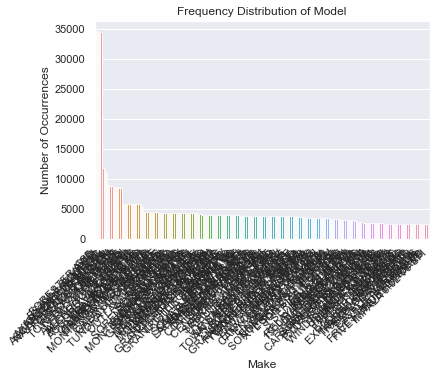

In [202]:
model_count = df_oversample.Model.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Model')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

In [203]:
df_oversample.Model.value_counts()

G35                     34516
FORESTER AWD            34511
ES300 3.0L V6 EFI       34508
COOPER                  34506
ASCENDER 2WD 6C         11805
                        ...  
FOCUS                    2377
FREESTAR FWD V6 3.9L     2374
FIVE HUNDRED 3.0L V6     2366
FIVE HUNDRED             2362
IMPALA 3.5L V6 SFI       2348
Name: Model, Length: 186, dtype: int64

In [116]:
colist = test["Make"].unique().tolist()
keys = colist
values = data = random.sample(range(45), 25)
noise_dict = dict(zip(keys, values))

In [119]:
noise_dict.items()

dict_items([('NISSAN', 6), ('CHEVROLET', 34), ('DODGE', 31), ('FORD', 10), ('SATURN', 40), ('BUICK', 43), ('KIA', 37), ('CHRYSLER', 16), ('MAZDA', 27), ('HONDA', 44), ('JEEP', 25), ('PONTIAC', 18), ('HYUNDAI', 29), ('MERCURY', 35), ('SUZUKI', 38), ('MITSUBISHI', 14), ('GMC', 36), ('TOYOTA', 5), ('OLDSMOBILE', 15), ('LINCOLN', 28), ('ISUZU', 42), ('SUBARU', 9), ('INFINITI', 21), ('MINI', 0), ('LEXUS', 12)])

In [121]:

colist = test["Make"].unique().tolist()
keys = colist
values = data = random.sample(range(45), 25)
noise_dict = dict(zip(keys, values))
df_oversample = test

for col , noise in noise_dict.items():
    msk = test["Make"] == col
    #new = test[msk].sample(n=num_to_oversample, replace =True)
    num_to_oversample =  test["Make"].value_counts().max() - msk.sum() - noise
    new = test[msk].sample(n=num_to_oversample, replace =True)
    df += pd.concat([df_oversample, new ])

TypeError: can only concatenate str (not "float") to str

In [104]:
print(num_to_oversample)

903


In [102]:
df_oversample["Make"].value_counts()

CHEVROLET     914
LEXUS         904
DODGE         722
FORD          708
CHRYSLER      478
PONTIAC       244
NISSAN        128
KIA           122
SATURN        119
HYUNDAI       114
JEEP          101
MERCURY        77
MITSUBISHI     61
SUZUKI         59
BUICK          49
MAZDA          47
TOYOTA         44
GMC            34
HONDA          32
OLDSMOBILE     20
LINCOLN         6
ISUZU           4
MINI            2
SUBARU          2
INFINITI        2
Name: Make, dtype: int64

In [64]:
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler()
#_resampled, y_resampled = ros.fit_resample(test.drop("Make", axis =1), test["Make"] ) 
#test["Make"].value_counts()

ModuleNotFoundError: No module named 'imblearn'

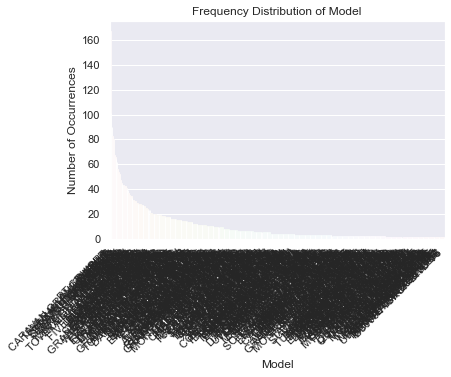

In [426]:
model_count = test.Model.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Model')
plt.ylabel('Number of Occurrences')
plt.xlabel('Model')
plt.show()

In [427]:
#Call the function on the make column  with a  threshold of 98%
transf_make_column,new_category_list=cumulatively_categorise(test.Make,threshold = 0.98, return_categories_list=True)



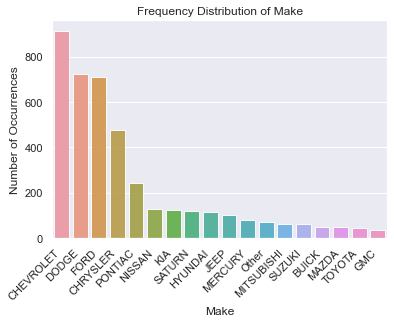

In [428]:
transf_make_column_count = transf_make_column.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(transf_make_column_count.index, transf_make_column_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

In [435]:
#Call the function on the make column  with a  threshold of 80%
transf_model_column,new_category_list=cumulatively_categorise(test.Model,threshold = 0.70, return_categories_list=True)



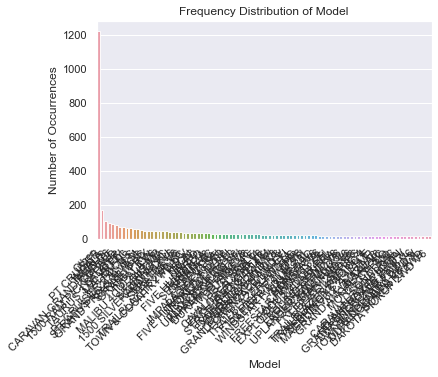

In [436]:
transf_model_column_count = transf_model_column.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(transf_model_column_count.index, transf_model_column_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Model')
plt.ylabel('Number of Occurrences')
plt.xlabel('Model')
plt.show()

In [ ]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

#X, y = oversample.fit_resample(X, y)

In [320]:
#convert text data to numeric before applying SMOTE 
from sklearn.feature_extraction.text import CountVectorizer

In [398]:
vectorizer = CountVectorizer()
vectorizer.fit(test.Make.values.ravel())
test.Make = vectorizer.transform(test.Make.values.ravel())


In [405]:
test.Make = test.Make.toarray()
test.Make

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [402]:
vectorizer2 = CountVectorizer()
vectorizer2.fit(test.Model.values.ravel())
test.Model = vectorizer2.transform(test.Model.values.ravel())


AttributeError: values not found

In [403]:
test.Model = test.Model.toarray()
test.Model

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [393]:
vectorizer3 = CountVectorizer()
vectorizer3.fit(test.Transmission.values.ravel())
test.Transmission = vectorizer3.transform(test.Transmission.values.ravel())


In [404]:
test.Transmission = test.Transmission.toarray()
test.Transmission

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

In [440]:
test.describe()

,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,predicted_label
count,4090.000000,4090.000000,4090.000000,4090.000000
mean,73238.441809,5781.391443,0.508068,0.482885
std,14078.099940,2365.500054,0.499996,0.499768
min,12628.000000,10.000000,0.000000,0.000000
25%,64135.000000,3880.250000,0.000000,0.000000
50%,74673.000000,5547.500000,1.000000,0.000000
75%,83582.250000,7386.000000,1.000000,1.000000
max,115717.000000,17229.000000,1.000000,1.000000


In [388]:



##vectorizer.fit(X_train.values.ravel())
##X_train=vectorizer.transform(X_train.values.ravel())
#X_test=vectorizer.transform(X_test.values.ravel())
#X_train=X_train.toarray()
#X_test=X_test.toarray()
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(test.drop("Make", axis = 1) , test.Make)


ValueError: could not convert string to float: 'ALTIMA'

In [303]:
transformed_column.value_counts()

CHEVROLET     914
DODGE         722
FORD          708
CHRYSLER      478
PONTIAC       244
Other         194
NISSAN        128
KIA           122
SATURN        119
HYUNDAI       114
JEEP          101
MERCURY        77
MITSUBISHI     61
SUZUKI         59
BUICK          49
Name: Make, dtype: int64

In [439]:
test[test.Make =="DODGE"].Model.value_counts()

CARAVAN GRAND FWD V6    83
1500 RAM PICKUP 2WD     67
CALIBER                 66
STRATUS V6 2.7L V6 M    52
STRATUS 4C              45
STRATUS V6              37
NEON                    33
NEON 2.0L I4 SFI        27
DURANGO 2WD V8          26
AVENGER 4C              23
STRATUS 4C 2.4L I4 M    21
DURANGO 4WD V8          20
CALIBER 2.0L I4 SFI     19
CHARGER V6              18
MAGNUM V6               17
MAGNUM V6 2.7L V6 MP    16
CARAVAN FWD V6 3.3L     15
DURANGO 2WD V8 4.7L     14
DURANGO 4WD V8 4.7L     14
DAKOTA PICKUP 2WD V6    13
DURANGO 2WD V6          12
CHARGER                 11
CARAVAN FWD 4C          10
CARAVAN FWD V6          10
STRATUS 4C 2.4L I4 S     9
CARAVAN FWD 4C 2.4L      6
CHARGER V6 2.7L V6 M     6
1500 RAM PICKUP 4WD      4
AVENGER 4C 2.4L I4 S     4
DURANGO 2WD V6 3.7L      4
MAGNUM V6 3.5L V6 MP     3
DAKOTA PICKUP 2WD V8     3
CHARGER 2.7L V6 MPI      3
NITRO 2WD V6             3
AVENGER V6               2
INTREPID 3.5L V6 MPI     2
NEON 2.0L I4 SFI / S     2
D